In [1]:
import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
from scipy import linalg
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cmap
import matplotlib
import os
import pandas as pd

import math

from numpy import absolute as A
from numpy import transpose as T

import natsort

import cv2
import time
import matplotlib.pyplot as plt

import networkx as nx

import umap
import seaborn as sns

import statsmodels.api

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
from sklearn.decomposition import NMF

from scipy import signal

In [16]:
# utility functions:

def normalize_by_rows (mat):

    mat_norm = np.zeros_like(mat)

    for r in range(0,np.shape(mat)[0]):

        mat_norm[r,:] = mat[r,:]/np.max((mat[r,:]))
    
    return mat_norm


def data_2_data_time(X, win):
    X_time = np.zeros((np.shape(X)[0]*win,np.shape(X)[1]))

    for t in range(0,np.shape(X)[1]-win):
        seg = np.reshape(X[:,t:t+win],(np.shape(X)[0]*win,1),order = "F")
        X_time[:,t] = seg[:,0]
        
    return X_time  

def find_centroids (xdata,ydata,etho_vec):
    
    numb_classes = int(np.max(pr_plot)-np.min(pr_plot))+1
    
    print(numb_classes)
    centroid_table = np.zeros((numb_classes,2))

    for cl in range(0,numb_classes):
        cl_xdata=xdata[etho_vec[:]==cl]
        cl_ydata=ydata[etho_vec[:]==cl]
        
        #print(cl)
        #print(np.nanmean(cl_xdata),np.nanmean(cl_ydata))

        centroid = [np.nanmean(cl_xdata),np.nanmean(cl_ydata)]
        centroid_table[cl,:] = centroid
        
    return centroid_table  

In [3]:
#LOAD datasets

#Name_combined_data = 'R35G04_DBX_Chrimson_ContONnandControl_vel'
#Folder_name = 'C:\\Users\\ravbar\\Desktop\\Transitions\\data\\combined_datasets\\'

Name_combined_data = 'R35G04_DBX_Chrimson_dusted_210msOn70msOFFANDcontrolconton_vel' #empty split chrimson
#Name_combined_data = 'DNp10_1608_Chrimson_EZandControlEmptyADDBDChrimSDS' #empty split chrimson
#Name_combined_data = 'DNp10_1049_ACR_YMandControlEmptyADDBDAcr' #empty split acer
#Name_combined_data = "ControlemptySPlitChrimSDSandCS"

Folder_name = 'C:\\Users\\ravbar\\Desktop\\Transitions\\data\\combined_datasets\\'
#Folder_name = 'C:\\Users\\primo\\Desktop\\USB\\Transitions\\Data\\combined_datasets\\'
#Folder_name = 'C:\\Users\\primoz\\Desktop\\USB\\python_code\\transitions\\data\\combined_datasets\\'




with open(Folder_name + "CF_tot" + Name_combined_data, "rb") as f:                            
    CF_tot = pickle.load(f)   
with open(Folder_name + "C_lags_tot" + Name_combined_data, "rb") as f:                            
    C_lags_tot = pickle.load(f)   
with open(Folder_name + "C_freq_tot" + Name_combined_data, "rb") as f:                            
    C_freq_tot = pickle.load(f)   
with open(Folder_name + "seg_feat_mat"+ Name_combined_data, "rb") as f:                            
    seg_feat_mat = pickle.load(f)
with open(Folder_name + "seg_feature_table"+ Name_combined_data , "rb") as f:                            
    seg_feature_table = pickle.load(f) 
with open(Folder_name + "mov_size_list_tot"+ Name_combined_data , "rb") as f:                            
    mov_size_list_tot = pickle.load(f)     
    
         

In [15]:
# LOAD DICT ##################################
"""
#Name_combined_data = 'DNp10_1049_ACR_YMandControlEmptyADDBDAcr'
Name_combined_data = "ControlemptySPlitChrimSDSandCS"

Folder_name = 'C:\\Users\\ravbar\\Desktop\\Transitions\\data\\combined_datasets\\'
#Folder_name = 'C:\\Users\\primo\\Desktop\\USB\\Transitions\\Data\\combined_datasets\\'
#Folder_name = 'C:\\Users\\primoz\\Desktop\\USB\\python_code\\transitions\\data\\combined_datasets\\'

with open(Folder_name + "dictAnalyzedData_" + Name_combined_data, "rb") as f:                            
    dictAnalyzedData = pickle.load(f)   

SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_22956/2467557105.py, line 11)

In [18]:
# UMAP of segments CREATE UMAP

raw_training_data = seg_feature_table

#choose features:

X0_3 =raw_training_data[0:3,:]
X9_15 =raw_training_data[9:15,:]
#X32 =raw_training_data[32,:]
X29 =raw_training_data[29,:]
X36 =raw_training_data[36,:]
#X40 =raw_training_data[40,:]
#X45 =raw_training_data[45,:]

X44_47 = raw_training_data[44:47,:]

X13_comb_X33 = seg_feature_table[33,:] * seg_feature_table[13,:] 

X9_15_MAX = raw_training_data[51+9:51+15,:]

X29_MAX = seg_feature_table[51+29,:] 

X_MAX_positions =  seg_feature_table[51+15:51+28,:] 
X_angles = seg_feature_table[82:87,:] 
X_joint_vel = seg_feature_table[88:93,:] 

# stack features:

#X = np.vstack((X0_3,X9_15,X29,X36,X44_47,X13_comb_X33,X9_15_MAX,X29_MAX)) #last working
X = np.vstack((X0_3,X9_15,X29,X36,X44_47,X13_comb_X33,X9_15_MAX,X29_MAX,X_angles,X_joint_vel))

X = np.nan_to_num(X)
X = normalize_by_rows(X)
X = np.transpose(X)

#select what to EXCLUDE:

orig_size = np.shape(X)
select_out = True

if select_out == True:
    
    select_ind = np.where(((np.absolute(seg_feature_table[13+51,:])>1) | (np.absolute(seg_feature_table[14+51,:])>1)) & \
    (seg_feature_table[30,:]>(-1))) #DUSTED SDS 9/21/23
    
    X_select = np.squeeze(X[select_ind,:],axis=0)

    X=X_select

lim1_train = 0
lim2_train = np.shape(X)[0]

X_train=X[lim1_train:lim2_train,:]

# train WITH or WITHOUT TEMPORAL CONTEXT:

X_train = T(data_2_data_time(T(X_train), 3)) #TEMPORAL context (last working) 3 --> segment in t-1, t , t+1 ("3" temp. context used in the manuscript)
#X_train = T(data_2_data_time(T(X_train), 1)) # NO TEMPORAL context!!

reducer_ang = umap.UMAP(
    n_neighbors=350,
    min_dist=0.1,
    n_components=2,
)

umap_emb_ang = reducer_ang.fit_transform(X_train)

if select_out == True:

    umap_emb_ang_select = reducer_ang.fit_transform(X_train)
    umap_emb_ang = np.zeros((orig_size[0],2))
    umap_emb_ang[select_ind,:] = umap_emb_ang_select

In [2]:
# classify by UMAP by DBSCAN

from sklearn.cluster import DBSCAN 


X_class=umap_emb_ang


db = DBSCAN(eps=0.2, min_samples=110).fit(X_class) #grid search 70 210

pr = db.labels_

pr_plot = np.zeros((1,len(pr)))
pr_plot[0,:] = pr+1

numb_classes = len(set(pr)) 
n_noise_ = list(pr).count(-1)

cont_class = np.zeros((1,np.shape(seg_feat_mat)[1]))

for s in range(1,np.shape(seg_feature_table)[1]):
    cut_start = int(seg_feature_table[31,s])
    cut_end = int(seg_feature_table[32,s])
    cont_class[0,cut_start:cut_end] = pr_plot[0,s]
    
cont_class_remove_noise = np.copy(cont_class) 
cont_class_remove_noise[0,cont_class[0,:]==0] = np.nan
    
cont_feat_class = np.zeros_like(seg_feat_mat)
cont_feat_class[:] = np.nan 
class_feat_stats = np.zeros((np.shape(seg_feat_mat)[0],numb_classes))

for cl in range(0,numb_classes):
    cont_feat_class[:,cont_class[0,:]==cl] = seg_feat_mat[:,cont_class[0,:]==cl]
    class_feat_stats[:,cl] = np.nanmean(cont_feat_class,axis=1)
    cont_feat_class[:] = np.nan    
    
pr_plot_neg = pr_plot - 1
    
syntaxOp = SyntaxOperator (numb_classes)

TP_mat = syntaxOp.get_TP(pr_plot)
TF_mat = syntaxOp.get_TF(pr_plot) 

NameError: name 'umap_emb_ang' is not defined

In [ ]:
# GRID SEARCH FOR UMAP by DBSCAN

#def UMAP_DBSCAN_grid (X_input):

X_class=umap_emb_ang

performance_grid = np.zeros((10,10))

for ind_eps,epsil in enumerate(np.arange(0.1,0.7,0.1)):
    for ind_min_samp,min_samp in enumerate(range(10,600,100)):

        db = DBSCAN(eps=epsil, min_samples=min_samp).fit(X_class) #

        pr = db.labels_

        pr_plot = np.zeros((1,len(pr)))
        pr_plot[0,:] = pr+1

        numb_classes = len(set(pr)) 
        print("numb of classes=",numb_classes)
        print(epsil)
        print(min_samp)
    
        performance_grid[ind_eps,ind_min_samp]=numb_classes

In [10]:
# classify by UMAP by AGG. (this is the method used for the manuscript)


numb_classes = 12 #choose number of classes

X_class=umap_emb_ang

cluster = AgglomerativeClustering(n_clusters=numb_classes, affinity='euclidean', linkage='ward')
pr = cluster.fit_predict(X_class)

pr_plot = np.zeros((1,len(pr))) #this is the DISCRETE ethogram
pr_plot[0,:] = pr

numb_classes = len(set(pr)) 
n_noise_ = list(pr).count(-1)

cont_class = np.zeros((1,np.shape(seg_feat_mat)[1]))

for s in range(1,np.shape(seg_feature_table)[1]):
    cut_start = int(seg_feature_table[31,s])
    cut_end = int(seg_feature_table[32,s])
    cont_class[0,cut_start:cut_end] = pr_plot[0,s]
    
cont_class_remove_noise = np.copy(cont_class) 
cont_class_remove_noise[0,cont_class[0,:]==0] = np.nan
    
cont_feat_class = np.zeros_like(seg_feat_mat) #this is the CONTINUOUS ethogram
cont_feat_class[:] = np.nan 
class_feat_stats = np.zeros((np.shape(seg_feat_mat)[0],numb_classes))

for cl in range(0,numb_classes):
    cont_feat_class[:,cont_class[0,:]==cl] = seg_feat_mat[:,cont_class[0,:]==cl]
    class_feat_stats[:,cl] = np.nanmean(cont_feat_class,axis=1)
    cont_feat_class[:] = np.nan    
    
pr_plot_neg = pr_plot - 1
    


In [14]:
#SAVE classification

classifcation_name = "_"

with open(Folder_name + "pr_plot_" + Name_combined_data + classifcation_name, "wb") as f:                            
    pickle.dump(pr_plot, f)   
with open(Folder_name + "class_feat_stats_" + Name_combined_data + classifcation_name, "wb") as f:                            
    pickle.dump(class_feat_stats, f)      
with open(Folder_name + "cont_class_" + Name_combined_data + classifcation_name, "wb") as f:                            
    pickle.dump(cont_class, f)      
with open(Folder_name + "UMAP_" + Name_combined_data + classifcation_name, "wb") as f:                            
    pickle.dump(umap_emb_ang, f)     
#with open(Folder_name + "control_end_cont_" + Name_combined_data, "wb") as f:                            
#    pickle.dump(control_end_cont, f)       
#with open(Folder_name + "control_end_seg_" + Name_combined_data, "wb") as f:                            
#    pickle.dump(control_end_seg, f)     

In [92]:
"""
# SAVE DICT ##################################################

classifcation_name = "_"

dictAnalyzedData["pr_plot"] = pr_plot
dictAnalyzedData["class_feat_stats"] = class_feat_stats
dictAnalyzedData["cont_class"] = cont_class
dictAnalyzedData["umap_emb_ang"] = umap_emb_ang
dictAnalyzedData["control_end_cont"] = control_end_cont
dictAnalyzedData["control_end_seg"] = control_end_seg


with open(Folder_name + "dictAnalyzedData_" + Name_combined_data + classifcation_name, "wb") as f:                            
    pickle.dump(dictAnalyzedData, f)   

C:\Users\ravbar\AppData\Local\Temp/ipykernel_22956/1282810798.py:37: RuntimeWarning: Mean of empty slice
  centroid = [np.nanmean(cl_xdata),np.nanmean(cl_ydata)]
posx and posy should be finite values


12


posx and posy should be finite values


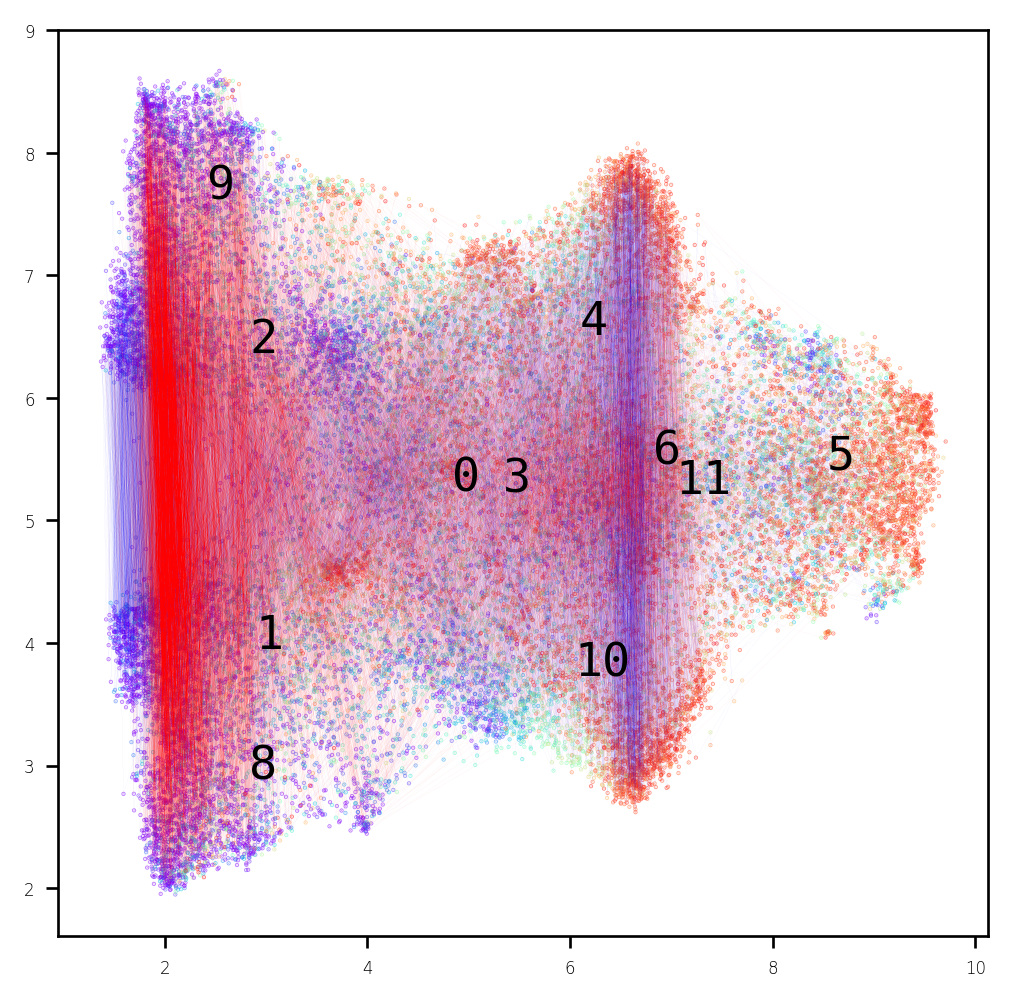

In [20]:
# plot UMAPs colored by features or classes:

fig = plt.figure(figsize=(5, 5), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)

#divide contol and experimental groups:

cut_1 = 18868
#cut_1 = 44157  #
#cut_2 = np.shape(umap_emb_ang)[0]
cut_2 = cut_1*2 #exp. group has same number of segments as the control

#lim1 = cut_1
#lim2 = cut_2

lim1 = 0
lim2 = cut_2

#lim1 = cut_1
#lim2 = cut_2

# select colors of the data to plot:

#col_f = seg_feature_table[13,lim1:lim2] #left ampl
#col_f = seg_feature_table[14,lim1:lim2] #right ampl
#col_f = seg_feature_table[0,lim1:lim2] #
#col_f = seg_feature_table[33,lim1:lim2] #SEG duration
col_f = seg_feature_table[36,lim1:lim2] #phase
#col_f = seg_feature_table[29,lim1:lim2] #velocity
#col_f = seg_feature_table[46,lim1:lim2] #freq
#col_f = seg_feature_table[40,lim1:lim2] #BOUT DURATIONS!
#col_f = seg_feature_table[86,lim1:lim2]

#col_f = pr_plot[0,lim1:lim2] #class membership
#col_f = pr_plot_new[0,lim1:lim2] #class membership new
#col_f = gr_mem[0,lim1:lim2] #group membership
#col_f = mov_time_name_table[lim1:lim2] #movie membership
#col_f = seg_feature_table[13,lim1:lim2] #
#col_f = seg_feature_table[51+0,lim1:lim2] #MAX feat 0

#col_f = seg_feature_table[31,lim1:lim2]

#col_f = seg_feat_mat[51+13,lim1:lim2]*np.sign(seg_feat_mat[13,lim1:lim2]) #add sign to absolute values
#ol_f = col_f + np.absolute(np.min(col_f))

#col_f = seg_feature_table[51+13,lim1:lim2] / seg_feature_table[33,lim1:lim2] 
#col_f = seg_feature_table[33,lim1:lim2] * seg_feature_table[13,lim1:lim2] 

col_f = np.nan_to_num(col_f)
col = col_f/np.max(col_f)

xdata = np.copy(umap_emb_ang[lim1:lim2,0])
ydata = np.copy(umap_emb_ang[lim1:lim2,1])

xdata_lines = np.copy(umap_emb_ang[:,0])
ydata_lines = np.copy(umap_emb_ang[:,1])

xdata[xdata==0] = np.nan    
ydata[ydata==0] = np.nan  

xdata_lines[xdata_lines==0] = np.nan    
ydata_lines[ydata_lines==0] = np.nan  

centroid_table = find_centroids (xdata,ydata,pr_plot[0,lim1:lim2])

#select clusters to EXCLUDE:

cl_excl = [99] #exclude clusters
#cl_excl = [0]
#cl_excl = [1]
#cl_excl = [0,1]
#cl_excl = [0,1,4,5,6,7,8,10,11,12,13,14]
#cl_excl = [0,1,3,4,5,6,7,10,11,12,13,14]
#cl_excl = [0,1,3,5,6,7,8,10,11,12,13,14]
#cl_excl = [0,1,3,4,5,6,8,10,11,12,13,14]
#cl_excl = [0,1,10,11,12,13,14] #best for trans classes

for c in cl_excl:
    
    xdata[pr_plot[0,lim1:lim2]==c]=np.nan
    ydata[pr_plot[0,lim1:lim2]==c]=np.nan
    xdata_lines[pr_plot[0,:]==c]=np.nan
    ydata_lines[pr_plot[0,:]==c]=np.nan

plt.scatter(xdata, ydata, s=0.3,marker='.', c=col, cmap='rainbow',alpha=0.5)
#plt.scatter(xdata, ydata, s=0.3,marker='.', c=col, cmap='rainbow',alpha=0.5)

#plot blue lines for control, red lines for experimental:
plt.plot(xdata_lines[0:cut_1], ydata_lines[0:cut_1],'b-',linewidth=0.005,alpha=0.99) 
plt.plot(xdata_lines[cut_1:cut_2], ydata_lines[cut_1:cut_2],'r-',linewidth=0.005,alpha=0.99)

#plt.plot(xdata_lines[0:cut_1], ydata_lines[0:cut_1],'k-',linewidth=0.005,alpha=0.99)
#plt.plot(xdata_lines[cut_1:cut_2], ydata_lines[cut_1:cut_2],'k-',linewidth=0.005,alpha=0.99)

for cl in range(0,numb_classes):
    
    if cl_excl.count(cl) == 0:

        plt.text(centroid_table[cl,0], centroid_table[cl,1], str(cl) , color=[0,0,0], fontsize=14,weight=200,fontfamily='monospace')

In [ ]:
#merge clusters:

clusters_to_merge=[11,4]
#clusters_to_merge=[4,9]

numb_classes = int(np.max(pr_plot)+1)
new_cluster = numb_classes + 0

#pr_plot_new = np.copy(pr_plot)

for cl in clusters_to_merge:

    pr_plot_new[0,pr_plot[0,:]==cl]=new_cluster


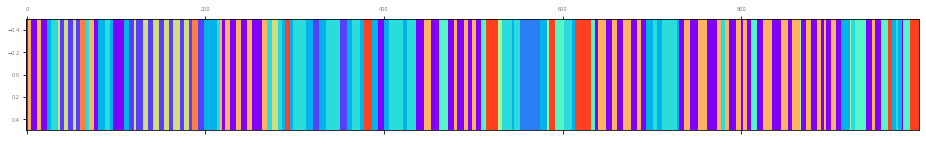

In [7]:
#plot ethogram sample:

lim1=100
lim2=lim1+1000

etho_to_plot = np.copy(cont_class[:,lim1:lim2])  #ethogram
etho_to_plot[0,0]=0;etho_to_plot[0,1]=numb_classes

#plt.matshow(cont_class_remove_noise[:,lim1:lim2],aspect="auto",cmap='rainbow')
plt.matshow(etho_to_plot,aspect="auto",cmap='rainbow')